In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook


In [3]:
data_df = pd.read_csv('./data/NAPS_valence_arousal_2014.csv', sep=';')
data_df.head()

,ID,Category,Nr,V_H,Description,Valence,Arousal
0,Animals_001_h,Animals,1,h,Dead Stork,"2,57","6,44"
1,Animals_002_v,Animals,2,v,Lion,"6,24","6,68"
2,Animals_003_h,Animals,3,h,Snake,"5,24","5,52"
3,Animals_004_v,Animals,4,v,Wolf,"4,50","7,02"
4,Animals_005_h,Animals,5,h,Bat,"5,31","5,82"


In [4]:
data_df['Valence_float'] = data_df['Valence'].map(lambda x: float(x.replace(',','.')))
data_df['Arousal_float'] = data_df['Arousal'].map(lambda x: float(x.replace(',','.')))

data_df.describe()

,Nr,Valence_float,Arousal_float
count,1356.000000,1356.000000,1356.000000
mean,144.870944,5.391947,5.101881
std,92.428420,1.628732,1.058333
min,1.000000,1.330000,2.040000
25%,68.000000,4.060000,4.430000
50%,136.000000,5.660000,4.980000
75%,208.250000,6.772500,5.820000
max,372.000000,8.540000,8.050000


In [5]:
def mapping(x, labels, series, percentile_width):
        for i in range(len(labels)):
            if x < series.quantile((i + 1) * percentile_width):
                return labels[i]

def divide_into(labels, series):
    range = series.max() - series.min()
    percentile_width = 1 / len(labels)
    
    return series.map(lambda x: mapping(x, labels, series, percentile_width))

data_df['Valence_class'] = divide_into(['low', 'medium', 'high'], data_df['Valence_float'])
data_df['Arousal_class'] = divide_into(['low', 'medium', 'high'], data_df['Arousal_float'])
data_df = data_df.filter(['ID', 'Valence_float', 'Arousal_float', 'Valence_class', 'Arousal_class'])

data_df.head(10)

,ID,Valence_float,Arousal_float,Valence_class,Arousal_class
0,Animals_001_h,2.57,6.44,low,high
1,Animals_002_v,6.24,6.68,medium,high
2,Animals_003_h,5.24,5.52,medium,medium
3,Animals_004_v,4.50,7.02,low,high
4,Animals_005_h,5.31,5.82,medium,high
5,Animals_006_v,5.13,6.23,medium,high
6,Animals_007_h,4.76,7.06,medium,high
7,Animals_008_v,2.63,6.80,low,high
8,Animals_009_v,5.79,5.61,medium,high
9,Animals_010_h,4.59,5.90,low,high


In [6]:
classification_data = data_df.filter(items=['ID', 'Valence_class', 'Arousal_class'])
classification_data.head()

,ID,Valence_class,Arousal_class
0,Animals_001_h,low,high
1,Animals_002_v,medium,high
2,Animals_003_h,medium,medium
3,Animals_004_v,low,high
4,Animals_005_h,medium,high


In [7]:
from os import listdir
import time
import datetime
import re
data_base_dir = './data/2018-afcai-spring/'

def read_filenames_regex(regex, dir):
    return list(filter(lambda filename: re.match(regex, filename), listdir(dir)))
    

    
def read_showed_images_file(dir_name):
    dir = data_base_dir + dir_name + '/'
    ts_filename = read_filenames_regex('.*timestamp.csv', dir)
    all_ts_file = pd.read_csv(dir + ts_filename[0], names=['filename', 'datetime'])
    without_trail = all_ts_file.loc[all_ts_file.iloc[:,0].str.contains(r'^((?!trail).)*$')]
    without_trail['image_id'] = without_trail['filename'].map(lambda x: re.search('[a-zA-Z]*_[0-9]*_[a-z]', x).group(0))
    without_trail['timestamp'] = without_trail['datetime'].map(lambda dt: int(datetime.datetime.strptime(dt, "%Y-%m-%d %H:%M:%S.%f").timestamp()*1000))
    images_df = without_trail.filter(['image_id', 'timestamp'])
    images_df['timestamp'] = images_df['timestamp'].map(lambda x: int(x/1000))
    images_df.set_index('timestamp', inplace=True)
    return fill_ts_indexes(images_df).sort_index()

def fill_ts_indexes(df):
    for i in range(min(df.index), max(df.index) + 10):
        if i in df.index:
            x = df.loc[i, 'image_id']
        else:
            df.loc[i] = [x]
    return df.sort_index()    

In [8]:
def read_bitalino_bpm(dir_name):
    dir = data_base_dir + dir_name + '/BITalino/'
    bpm_file = dir + read_filenames_regex('.*BPM.*', dir)[0]
    return pd.read_csv(bpm_file)

def read_bitalino_gsr(dir_name):
    dir = data_base_dir + dir_name + '/BITalino/'
    bpm_file = dir + read_filenames_regex('.*GSR.*', dir)[0]
    return pd.read_csv(bpm_file)

def read_person_data_from(dir_name, process_function):
    if dir_name[0] == 'B':
        gsr = process_function(read_bitalino_gsr(dir_name))
        bpm = process_function(read_bitalino_bpm(dir_name))
    showed_images = read_showed_images_file(dir_name)
    bpm = bpm.rename(columns={'value':'bpm'})
    gsr = gsr.rename(columns={'value':'gsr'})
    person_data = {'images': showed_images, 'bpm': bpm, 'gsr': gsr}
    person_data = drop_redundat_measurements(person_data)
    person_data = person_data['bpm'].join(person_data['gsr']).join(person_data['images'])
    return person_data.join(data_df.set_index('ID'), on='image_id')

    
def drop_redundat_measurements(person_data):
    person_data['bpm'].drop([ts for ts in person_data['bpm'].index.tolist() if ts not in person_data['images'].index.tolist()], inplace=True)
    person_data['gsr'].drop([ts for ts in person_data['gsr'].index.tolist() if ts not in person_data['images'].index.tolist()], inplace=True)
    return person_data

    
def mean_for(millis, ts_val_df):
    ts_val_df['timestamp'] = ts_val_df['timestamp'].map(lambda x: int(x/1000))
    ts_val_df = ts_val_df.groupby(['timestamp']).mean()
    ts_val_df['value'] = ts_val_df[' value'].map(lambda x: int(x))
    return ts_val_df.filter(['value'])
    
def one_sec_mean(ts_val_df):
    return mean_for(1000, ts_val_df)

identity = lambda x: x
    
    
person_data = read_person_data_from('B365', one_sec_mean)

C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()
C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


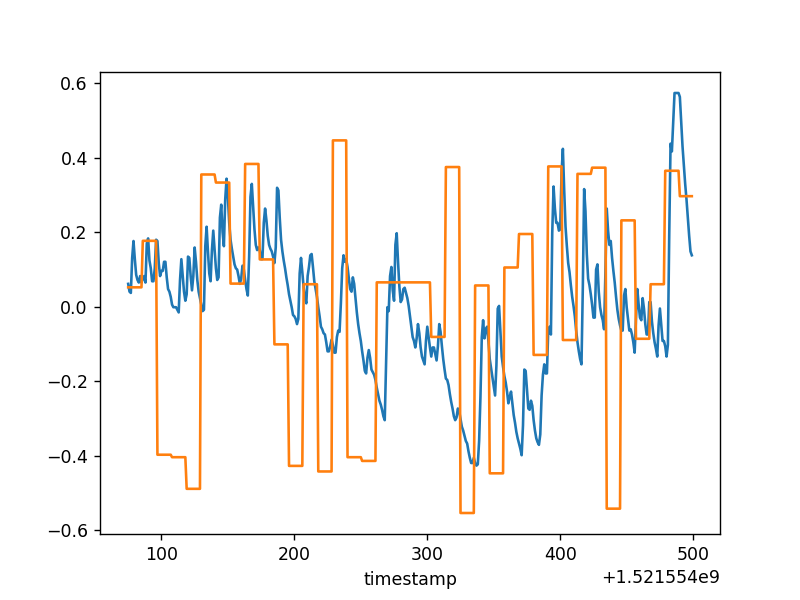

In [9]:
def normalize(df):
    return (df - df.mean()) / (df.max() - df.min())

# normalize(person_data['bpm']).plot()
normalize(person_data['gsr'].shift(periods=0)).plot()

normalize(person_data['Arousal_float']).plot()
# normalize(person_data['Arousal_float']).plot()

# example data plotted

In [158]:
# basic learning
def extract_features(person_data):

    def process_frame(frame):
        vec = frame['bpm'].tolist()[:10] + frame['gsr'].tolist()[:10]
        return vec


    learning_df = person_data.filter(['image_id', 'bpm', 'gsr', 'Arousal_class', 'Valence_class'])
    
    learning_df.fillna(value='medium', inplace=True)

    to_predict = 'Valence_class'

    X = []
    y = []
    
    for image in learning_df['image_id'].unique():
        image_df = learning_df.loc[learning_df['image_id'] == image]
        y.append(image_df.filter(['Valence_class', 'Arousal_class']).iloc[1].tolist())
        X.append(process_frame(image_df.filter(['bpm', 'gsr'])))
        
    y = list(map(lambda x: ",".join(x), y))
    
    return X, y

X, y = extract_features(person_data)

In [169]:
# basic logistic regression model for one person

from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)

logreg = linear_model.LogisticRegression(C=1e3)

logreg.fit(X_train, y_train)

logreg.score(X_test, y_test)

0.3625

In [46]:
# reading all bitalino data

bitalino_dirs = read_filenames_regex('B.*', data_base_dir)
bitalino_data = list(map(lambda x: read_person_data_from(x, one_sec_mean) ,bitalino_dirs))

C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()
C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mateu\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [172]:
X = []
y = []

# concatenate all data
for person in bitalino_data:
    _X, _y = extract_features(person)
    X = X + _X
    y = y + _y

In [174]:
# create learning model for all persons examined by BITalino

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

logreg = linear_model.LogisticRegression()

cross_val_score(logreg, X, y, cv=5)

array([0.36940299, 0.36329588, 0.38576779, 0.36981132, 0.36603774])